# Kaggle Based Models

This notebook produces predictive models on the kaggle dataset. The train, test and weather data are used from the original Kaggle competition. This allows us to at-least have some idea of the types of modeling, their performances etc, before we switch to our own train+validation+test splits and additional predictors.

To be honest, if this approach works, well, perhaps we can continue using it?

In [82]:
library("tidyverse")
library("xts")
library("dygraphs")
library("janitor")

## Import the training data

In [83]:
kag_train <- read_csv("../data/raw/kaggle/train.csv") %>% clean_names()
kag_train %>% sample_n(10)

Parsed with column specification:
cols(
  Date = col_date(format = ""),
  Address = col_character(),
  Species = col_character(),
  Block = col_integer(),
  Street = col_character(),
  Trap = col_character(),
  AddressNumberAndStreet = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  AddressAccuracy = col_integer(),
  NumMosquitos = col_integer(),
  WnvPresent = col_integer()
)


date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
2007-09-04,"2500 South Throop Street, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,25,S THROOP,T051,"2500 S THROOP, Chicago, IL",41.84628,-87.65691,9,1,0
2011-07-15,"Ohare Court, Bensenville, IL 60106, USA",CULEX PIPIENS,10,W OHARE,T903,"1000 W OHARE, Chicago, IL",41.95780,-87.93099,5,5,0
2009-07-17,"5000 South Central Avenue, Chicago, IL 60638, USA",CULEX RESTUANS,50,S CENTRAL AVE,T031,"5000 S CENTRAL AVE, Chicago, IL",41.80150,-87.76342,9,31,0
2013-09-19,"5100 North Mont Clare Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,51,N MONT CLARE AVE,T223,"5100 N MONT CLARE AVE, Chicago, IL",41.97384,-87.80506,9,5,0
2011-06-30,"Chicago Midway International Airport (MDW), 5200 West 63rd Street, Chicago, IL 60638, USA",CULEX RESTUANS,52,W 63RD ST,T065,"5200 W 63RD ST, Chicago, IL",41.77830,-87.75241,9,20,0
2007-09-24,"6700 South Kedzie Avenue, Chicago, IL 60629, USA",CULEX TERRITANS,67,S KEDZIE AVE,T066,"6700 S KEDZIE AVE, Chicago, IL",41.77166,-87.70305,8,3,0
2009-07-10,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.68259,-87.70797,9,50,0
2011-07-15,"6700 South Kedzie Avenue, Chicago, IL 60629, USA",CULEX TERRITANS,67,S KEDZIE AVE,T066,"6700 S KEDZIE AVE, Chicago, IL",41.77166,-87.70305,8,1,0
2009-06-29,"ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA",CULEX PIPIENS/RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.97469,-87.89061,9,45,0
2013-08-01,"8200 South Kostner Avenue, Chicago, IL 60652, USA",CULEX PIPIENS/RESTUANS,82,S KOSTNER AVE,T225,"8200 S KOSTNER AVE, Chicago, IL",41.74340,-87.73144,8,20,1


There seem to be instances where the same date+trap_id is used, even the same species, yet data is spread over 2 rows. Why? I'm consolidating this first..

In [84]:
kag_train[615:635,]

date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,1
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0
2007-07-25,"South Doty Avenue, Chicago, IL, USA",CULEX PIPIENS,12,S DOTY AVE,T115,"1200 S DOTY AVE, Chicago, IL",41.67341,-87.59986,5,50,0


In [85]:
kag_train[578:579,]

date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
2007-07-19,"South Torrence Avenue, Chicago, IL, USA",CULEX PIPIENS,13,S TORRENCE AVE,T200,"1300 S TORRENCE AVE, Chicago, IL",41.67862,-87.55931,5,7,0
2007-07-19,"South Torrence Avenue, Chicago, IL, USA",CULEX PIPIENS,13,S TORRENCE AVE,T200,"1300 S TORRENCE AVE, Chicago, IL",41.67862,-87.55931,5,2,0


So my logic is : for each [date + trap id + species], add up the mosq count and the wnv count.

In [86]:
mosq_by_date = kag_train %>% group_by(date,trap,species) %>% summarise(total_mosq=sum(num_mosquitos),total_wnv = sum(wnv_present)) %>% ungroup()
mosq_by_date %>% sample_n(10)

date,trap,species,total_mosq,total_wnv
2009-08-13,T065,CULEX RESTUANS,1,0
2011-06-17,T152,CULEX RESTUANS,1,0
2013-07-12,T090,CULEX RESTUANS,27,0
2011-07-15,T082,CULEX RESTUANS,6,0
2013-08-22,T061,CULEX RESTUANS,1,1
2007-08-07,T159,CULEX TERRITANS,2,0
2011-07-11,T200,CULEX RESTUANS,11,0
2007-09-12,T012,CULEX PIPIENS/RESTUANS,1,0
2013-09-19,T011,CULEX PIPIENS,1,0
2013-08-01,T046,CULEX RESTUANS,3,0


In [87]:
mosq_by_date = mosq_by_date %>% tidyr::spread(species,total_mosq,fill = 0) %>% clean_names() %>% mutate(total_mosq = culex_erraticus+culex_pipiens+culex_pipiens_restuans+culex_restuans+culex_salinarius+culex_tarsalis+culex_territans)
mosq_by_date %>% sample_n(5)

date,trap,total_wnv,culex_erraticus,culex_pipiens,culex_pipiens_restuans,culex_restuans,culex_salinarius,culex_tarsalis,culex_territans,total_mosq
2007-08-24,T062,0,0,2,0,0,0,0,0,2
2013-07-08,T158,0,0,0,28,0,0,0,0,28
2011-08-12,T062,0,0,0,2,0,0,0,0,2
2009-06-26,T090,0,0,0,3,5,0,0,0,8
2009-06-02,T089,0,0,1,2,3,0,0,0,6


If I just keep the "presence" of different types of mosq, (0/1 indicator), will I see some reduction in vars after running PCA?

In [88]:
just_mosq_presence = mosq_by_date %>% select(contains("culex")) %>% map_df(~as.numeric(.x>0))
head(just_mosq_presence)

culex_erraticus,culex_pipiens,culex_pipiens_restuans,culex_restuans,culex_salinarius,culex_tarsalis,culex_territans
0,0,1,1,0,0,0
0,0,0,1,0,0,0
0,0,1,1,0,0,0
0,0,0,1,0,0,0
0,0,0,1,0,0,0
0,0,1,1,0,0,0


In [89]:
pcaFit = princomp(~., just_mosq_presence)
summary(pcaFit)

Importance of components:
                          Comp.1    Comp.2    Comp.3     Comp.4     Comp.5
Standard deviation     0.5442434 0.4630311 0.3897483 0.20504992 0.12781586
Proportion of Variance 0.4100780 0.2968250 0.2103045 0.05821023 0.02261776
Cumulative Proportion  0.4100780 0.7069030 0.9172075 0.97541776 0.99803552
                            Comp.6       Comp.7
Standard deviation     0.034874857 0.0142370200
Proportion of Variance 0.001683856 0.0002806198
Cumulative Proportion  0.999719380 1.0000000000

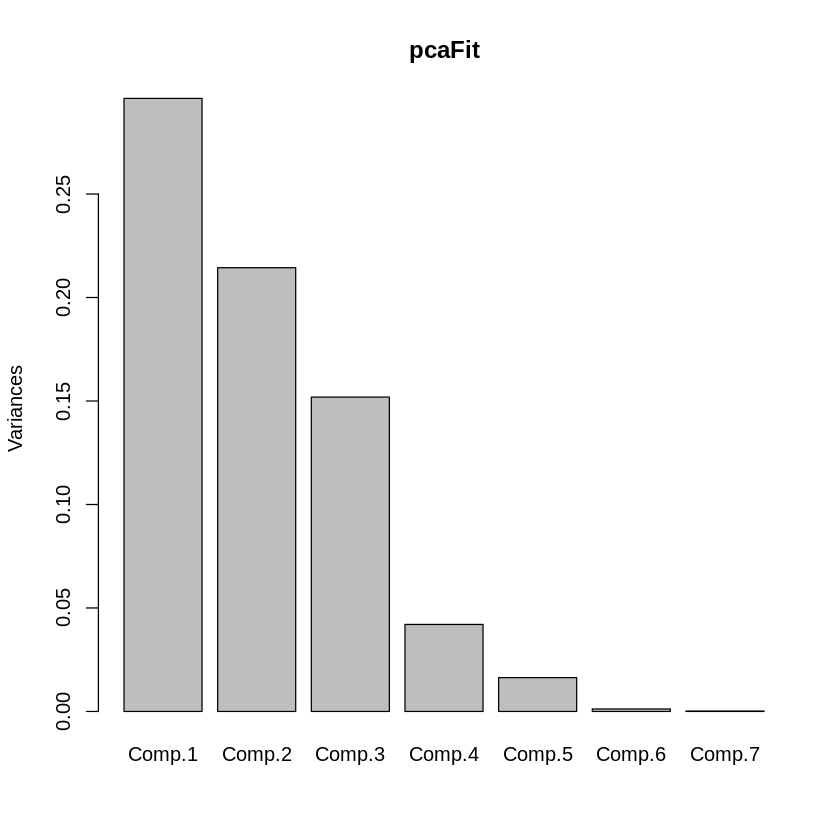

In [90]:
plot(pcaFit)

In [91]:
pca_mosq_components = pcaFit$scores[,1:3]
colnames(pca_mosq_components) = c("pca_species_1","pca_species_2","pca_species_3")
pca_mosq_components = as_tibble(pca_mosq_components)
head(pca_mosq_components)

pca_species_1,pca_species_2,pca_species_3
-0.6494156,0.08530339,-0.2054377
-0.6390055,-0.50154211,0.6041849
-0.6494156,0.08530339,-0.2054377
-0.6390055,-0.50154211,0.6041849
-0.6390055,-0.50154211,0.6041849
-0.6494156,0.08530339,-0.2054377


In [92]:
mosq_by_date = mosq_by_date %>% select(-contains("culex")) %>% bind_cols(pca_mosq_components)
head(mosq_by_date)

date,trap,total_wnv,total_mosq,pca_species_1,pca_species_2,pca_species_3
2007-05-29,T002,0,2,-0.6494156,0.08530339,-0.2054377
2007-05-29,T007,0,1,-0.6390055,-0.50154211,0.6041849
2007-05-29,T015,0,5,-0.6494156,0.08530339,-0.2054377
2007-05-29,T045,0,2,-0.6390055,-0.50154211,0.6041849
2007-05-29,T046,0,1,-0.6390055,-0.50154211,0.6041849
2007-05-29,T048,0,3,-0.6494156,0.08530339,-0.2054377


In [101]:
library(lattice)

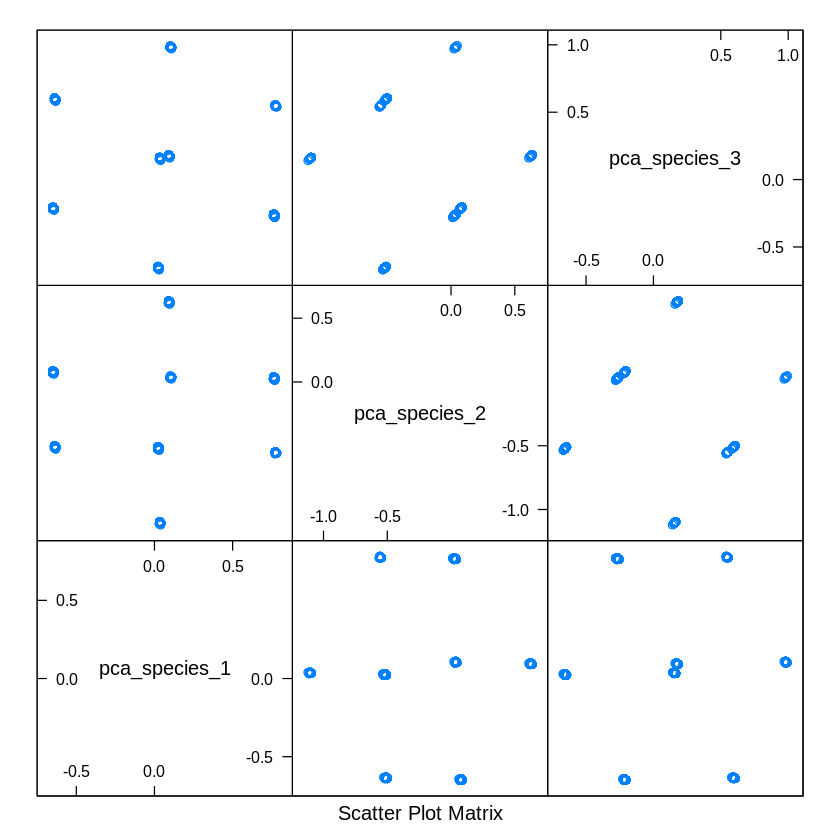

In [103]:
splom(mosq_by_date[,5:7])

In [93]:
## ------------------------------------------------------------------------
trap_metadata = kag_train %>% select(trap, latitude, longitude, address_accuracy, address) %>% distinct()
trap_metadata = trap_metadata %>% mutate(zipcode = stringr::str_extract(address,pattern = "\\d{5}")) %>% select(-address)

In [94]:
## ------------------------------------------------------------------------
head(trap_metadata)

trap,latitude,longitude,address_accuracy,zipcode
T002,41.95469,-87.80099,9,60634
T007,41.99499,-87.76928,9,60646
T015,41.97409,-87.82481,8,60656
T045,41.92160,-87.66645,8,60614
T046,41.89112,-87.65449,8,60654
T048,41.86711,-87.65422,8,60608


Warning message:
“Removed 12 rows containing missing values (geom_label).”

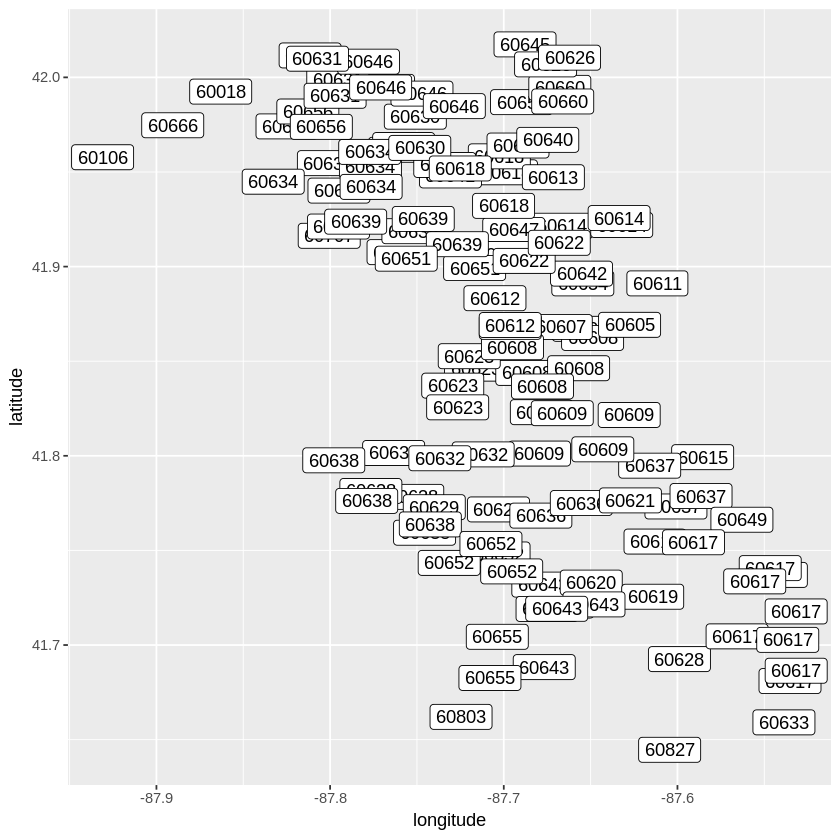

In [106]:
ggplot(trap_metadata) +
    geom_label(aes(longitude, latitude, label=zipcode))

In [95]:
## ------------------------------------------------------------------------
ohare = c(41.99,-87.933,662)
midway = c(41.786,-87.752,612)

Haversine distance to get the distance of each trap from the weather station

In [96]:
## ------------------------------------------------------------------------
hav.dist <- function(long1, lat1, long2, lat2) {
  R <- 6371
  diff.long <- (long2 - long1)
  diff.lat <- (lat2 - lat1)
  a <- sin(diff.lat/2)^2 + cos(lat1) * cos(lat2) * sin(diff.long/2)^2
  b <- 2 * asin(pmin(1, sqrt(a))) 
  d = R * b
  return(d)
}

In [97]:
## ------------------------------------------------------------------------
trap_metadata %>% 
    mutate(ohare_dist = hav.dist(longitude,ohare[2],latitude,ohare[1]),
           midway_dist = hav.dist(longitude,midway[2],latitude,midway[1])) -> trap_metadata
head(trap_metadata)

trap,latitude,longitude,address_accuracy,zipcode,ohare_dist,midway_dist
T002,41.95469,-87.80099,9,60634,8666.675,8972.917
T007,41.99499,-87.76928,9,60646,8685.343,8998.808
T015,41.97409,-87.82481,8,60656,8761.627,9104.600
T045,41.92160,-87.66645,8,60614,8324.615,8498.112
T046,41.89112,-87.65449,8,60654,8245.438,8388.021
T048,41.86711,-87.65422,8,60608,8201.641,8327.079


Let's only keep the station which is closest to the trap. Then, we'll join the appropriate weather data to this trap.

In [98]:
trap_metadata = trap_metadata %>% mutate(station = ifelse(ohare_dist < midway_dist, 1, 2)) %>% select(-ohare_dist, -midway_dist)
head(trap_metadata)

trap,latitude,longitude,address_accuracy,zipcode,station
T002,41.95469,-87.80099,9,60634,1
T007,41.99499,-87.76928,9,60646,1
T015,41.97409,-87.82481,8,60656,1
T045,41.92160,-87.66645,8,60614,1
T046,41.89112,-87.65449,8,60654,1
T048,41.86711,-87.65422,8,60608,1


Joining, by = "trap"


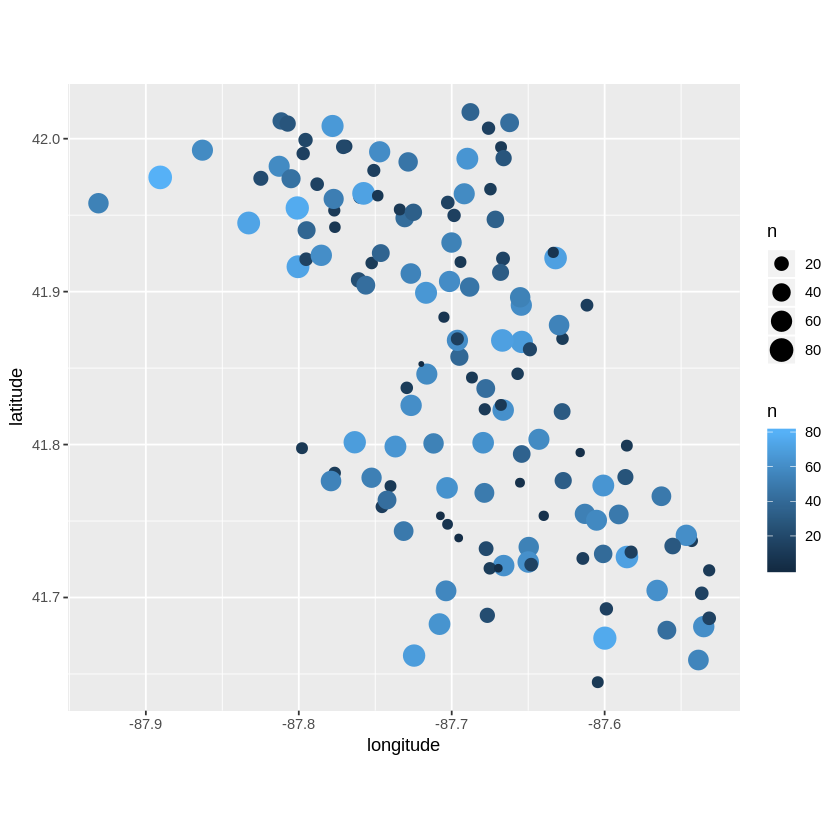

In [99]:
## ------------------------------------------------------------------------
trap_counts = mosq_by_date %>% count(trap)
trap_metadata %>% 
    left_join(trap_counts) %>% 
    ggplot(aes(longitude,latitude,color=n,size=n),alpha=0.4)+
    geom_point()+
    coord_fixed(ratio = 1)

## Import weather data

In [100]:
## ------------------------------------------------------------------------
weather_data <- read_csv("../data/raw/kaggle/weather.csv")
head(weather_data)

Parsed with column specification:
cols(
  .default = col_character(),
  Station = col_integer(),
  Date = col_date(format = ""),
  Tmax = col_integer(),
  Tmin = col_integer(),
  DewPoint = col_integer(),
  ResultSpeed = col_double(),
  ResultDir = col_integer()
)
See spec(...) for full column specifications.


Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,⋯,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2007-05-01,83,50,67,14,51,56,0,2,⋯,NA,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
2,2007-05-01,84,52,68,M,51,57,0,3,⋯,NA,M,M,M,0.00,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47,14,0,⋯,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
2,2007-05-02,60,43,52,M,42,47,13,0,⋯,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
1,2007-05-03,66,46,56,2,40,48,9,0,⋯,NA,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
2,2007-05-03,67,48,58,M,40,50,7,0,⋯,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2


In [ ]:
## ------------------------------------------------------------------------
date_vec = weather_data$Date
int_cols = weather_data %>% select_if(is_numeric) %>% select(-Date)
chr_cols = weather_data %>% select_if(is_character)

In [ ]:
## ------------------------------------------------------------------------
replace_m_with_na <- function(x){
    x[x=="M"] = NA
    x[x=="-"] = NA
    x
}
replace_t_with_na <- function(x){
    x[x=="T"] = NA
    x
}

In [ ]:
## ------------------------------------------------------------------------
int_cols = int_cols %>% purrr::map_df(~replace_m_with_na(.x)) %>% purrr::map_df(~replace_t_with_na(.x))
chr_cols = chr_cols %>% purrr::map_df(~replace_m_with_na(.x)) %>% purrr::map_df(~replace_t_with_na(.x))

In [ ]:
## ------------------------------------------------------------------------
weather_data = tibble(date = date_vec) %>% bind_cols(int_cols, chr_cols)
head(weather_data)

## ------------------------------------------------------------------------
weather_data <- weather_data %>% 
    mutate(
        Sunset = lubridate::fast_strptime(as.character(Sunset),format = "%H%M",lt = FALSE),
        Sunrise = lubridate::fast_strptime(as.character(Sunrise),format = "%H%M",lt = FALSE),
        day_time = as.numeric(Sunset-Sunrise)
    ) %>% 
    select(-Sunset,-Sunrise)

## ------------------------------------------------------------------------
weather_data <- weather_data %>% select(-CodeSum)

In [ ]:
## ------------------------------------------------------------------------
weather_data[,-1] <- weather_data[,-1] %>% purrr::map_df(~as.numeric(.x))
head(weather_data)

In [ ]:
## ------------------------------------------------------------------------
library(missForest)
library(doParallel)
library(foreach)
#cl <- parallel::makeCluster(18)
registerDoParallel(cores = 15)
mfFit <- missForest(xmis = as.matrix(weather_data[,-1]),ntree = 150)

## ------------------------------------------------------------------------
weather_impute = mfFit$ximp
weather_impute = tibble(date = weather_data$date) %>% bind_cols(as_tibble(weather_impute))

## ------------------------------------------------------------------------
head(weather_impute)

In [ ]:
## ------------------------------------------------------------------------
train_X = mosq_by_date %>% 
    left_join(trap_metadata) %>% 
    left_join(weather_impute) %>% 
    select(-latitude, -longitude) %>% 
    separate(date,c("year","month","date")) %>% 
    mutate(SnowFall = round(SnowFall,2)) %>% 
    mutate_at(c("year","month","date"),as.numeric) %>% 
    mutate(trap=as.factor(trap))

In [ ]:
## ------------------------------------------------------------------------
head(train_X)

## ------------------------------------------------------------------------
dim(train_X)

In [ ]:
## ------------------------------------------------------------------------
library(randomForest)
?randomForest
randomForest(x=train_X[,c(-4,-6)],y = train_X[[6]],ntree = 150)